# Chemical space の可視化
- 化合物空間の可視化は色々な方法がありますが、ここではtSNEを利用します。クラスタリング手法HDBSCANを利用します。DPP4阻害剤の特許データをクラスタリングして化合物の比較してみましょう。

- 今回、可視化にはBokeh描画ライブラリを利用します。Bokehを利用することで動的な図を作成することができます。また、データは米国で上市された薬剤の基本物質特許に記載祭されている実施例を利用します
- 該当する特許については[Orange book](https://www.accessdata.fda.gov/scripts/cder/ob/index.cfm?resetfields=1) から取得しました。

In [11]:
from ipywidgets import interact
import numpy as np
from bokeh.io import push_notebook, show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.plotting import ColumnDataSource

import pandas as pd
import numpy as np
#from sklearn.manifold import TSNE
from openTSNE import TSNE
import pathlib
import sys
import os
#　実行するノートブックのパスを取得します
notedir = pathlib.Path().resolve()
print(notedir)

output_notebook()

/Users/kzfm/python/cheminfotutorial1023/01_dataprep


Loading BokehJS ...

## パッケージのインポートと化合物をSVGに変換する関数の定義

[useful_rdkit_utils]( https://github.com/PatWalters/useful_rdkit_utils)は[Patrick walter](http://practicalcheminformatics.blogspot.com/)氏が開発しているrdkitのラッパー関数をまとめているパッケージです。これを利用することでFingerprintの計算などのCodingが非常に簡便にできます。

*注) Patrick Walter氏は上記のパッケージに限らずケモインフォマティクス関連の情報を多数発信していますので、興味があればフォローするとよいでしょう。*

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import rdDepictor
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
from useful_rdkit_utils import mol2numpy_fp

def mol2svg(mol):
    rdDepictor.Compute2DCoords(mol)
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

## ToDo 化合物データの作成
- dpp4.xlsxに今回の作業に使うDPP4阻害剤とその該当する物質特許のリストを記載しています。
- 該当特許から抽出したTSVは../patentsにそれぞれTSVファイルとして格納してあります。
- ここで下記の作業を実施して下さい。
    1. TSVファイルを一つに統合
    2. Headerとして#SMILES	StructureSource	IdentifierType	IdentifierValueが含まれていますが、これと合わせて特許番号(patent_numberというプロパティで付与して下さい)を付与して下さい。後で使います。
    3. SDF(merged_dpp4.sdf)としてこのノートブックと同じディレクトリに保存
- 作業の時間を20分ほど取ります。
- 今回の特許データはNextmove社のPatFetchを利用し取得しました。本ツールの利用事例は大会ポスターセッションにて、発表がありますので興味があれば聴講して下さい。

注) WIPOから提供される特許情報はPDF、OCRで変換されたXMLなど、解析するためになんらかの処理が必要となりますが、USPTOから提供される特許情報の場合はCDXというMachine readableな形式（出願時に画像で構造を記載している場合）ですのでデータ解析が非常に楽になります。どちらを利用するかは一長一短ありますので実施したい解析に応じて使い分けるとよいでしょう。


In [15]:
## TSV＞＞＞SDF作成のコードをここに書きましょう！

import glob
# PandasToolsを使うとCSVからSDFへの変換が簡単に行えます。
from rdkit.Chem import PandasTools
# 出力するファイル名
output_file = "merged_dpp4.sdf"
# 特許情報を格納しているディレクトリ情報を定義
patdata_dir = os.path.join(notedir, '..', 'patents')
# ファイルパスをglob を利用して取得します。
patdata_files = glob.glob(patdata_dir+"/*.tsv")
# ４つのTSVを読み込み、Patent番号をファイル名から取得、それをデータフレームに追加します。
# ファイルは特許番号_xxxxx_examplified.tsvという形式になっています。
#
dfs = []
for patdata_file in patdata_files:
    pat_num = pathlib.Path(patdata_file).stem.split("_")[0]
    df = pd.read_csv(patdata_file, sep='\t')
    df["patent_number"] = pat_num
    dfs.append(df)

merge_df = pd.concat(dfs)

#PandasToolsのメソッドからデータフレームにRDKITモルオブジェクトを付与するコードを書き入れましょう
PandasTools.AddMoleculeColumnToFrame(merge_df, smilesCol="#SMILES")

#PandasToolsのメソッドからSDFに出力するコードを書きましょう
PandasTools.WriteSDF(merge_df, "merged_dpp4.sdf", properties=merge_df.columns)

## 化合物データの読み込み
- 作業が終わりましたら、ファイルを読み込みます。
- 最初に定義した標準化ファイルを使って分子を正規化しましょう！

In [16]:
parent_dir = os.path.abspath(os.path.join(notedir, os.pardir))
# cheminfo_util をimportします。
sys.path.append(parent_dir)
print(parent_dir)
#cheminfo_utilの実装が終わったらコメントアウト
#import cheminfo_util
mols = [m for m in Chem.SDMolSupplier(os.path.join(notedir, 'merged_dpp4.sdf'))]
print(len(mols))
#cheminfo_utilの実装が終わったらコメントアウト
#mols = [cheminfo_util.prep_moleclue(m) for m in mols if cheminfo_util.prep_moleclue(m) != None]
print(len(mols))

/Users/kzfm/python/cheminfotutorial1023
319
319


In [17]:
mols[0].GetPropsAsDict()

{'#SMILES': 'N1(C(N(C(=CC1=O)N2C[C@@H](CCC2)N)CC=3C=CC=CC3C#N)=O)CC',
 'StructureSource': 'US08288539-20121016-C00038.CDX',
 'IdentifierType': 'Compound',
 'IdentifierValue': 5,
 'patent_number': 'US8288539B2'}

## 化合物を二次元空間にマッピングする

- 今回のコードではmol2numpy_fp関数を利用することで簡便にNumpy形式のFingerprintを生成しますが、これを使わずRDKitの関数を利用するのであれば以下のようなコードになります。
- MorganFingerprintはAllChem.GetMorganFingerprintとして取得することもできますが非推奨です。rdFingerPrintGeneratorの利用が推奨されています。（なお、どちらを使っても特にWarningは出ません。）
- 将来的にDeprication warningが出る可能性はあります（rdkit ugm hackathon topicsでした）。
```python
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
fpgen = rdFingerprintGenerator.GetMorganGenerator(2,1024)
fps = [fpgen.GetCountFingerprintAsNumPy(mol) for mol in mols]
```

tSNEの実行にはscikit-learnに実装されているものではなくopen-TSNEの実装を利用します。[Scikit-learnの実装はtransformが利用できない]( https://stackoverflow.com/questions/59214232/python-tsne-transform-does-not-exist)ため、作成した空間に新しいデータををマッピングすることができません。

tSNEでケミカルスペースの描画のための座標を取得しますが、今回の例ではHDBSCANを併用してソフトクラスタリングも実施します。
HDBSCANではデータの密度を加味した階層別クラスタリングを実施し適当な数のクラスタに分割するためtSNEのケミカルスペースの把握に役立ちます。

In [18]:
fps = np.array([mol2numpy_fp(m, radius=2, nBits=1024) for m in mols])
molsvgs = [mol2svg(m) for m in mols]

patnum = [m.GetProp('patent_number') for m in mols]
tsne = TSNE(random_state=0,
            perplexity=50,
            n_iter=500,)
#res = tsne.fit_transform(fps)
res = tsne.fit(fps)
from sklearn.cluster import HDBSCAN
from rdkit.Chem import DataStructs
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral

def tanimoto_dist(a,b):
    dotprod = np.dot(a,b)
    tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
    return 1.0-tc

hdbscan = HDBSCAN(min_cluster_size=8, metric=tanimoto_dist).fit(fps)
#hdbscan = HDBSCAN(min_cluster_size=8).fit(res)

- factor_cmap を利用してクラスタID毎に色を付けますが、factor_cmapに渡すラベルはStringである必要があるのでstrで型変換します。
- -1のラベルがついているのはノイズと判定されたものでありクラスタと認識されないデータセットになります。
- min_cluster_sizeを変えると出力結果が異なります。

In [19]:
factors = sorted(set([str(l) for l in hdbscan.labels_]))
factors = list(factors)
palette = Spectral[len(factors)]
print(len(factors))
mapper = factor_cmap(field_name='label', palette=palette ,
                     factors=factors
                    )
print(hdbscan.labels_)

5
[ 2  2  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  2  2  2 -1  2
  2  2  2  2  2  2 -1 -1 -1 -1 -1 -1  2 -1  3  3 -1  3 -1  3 -1 -1 -1  3
 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3  3  3 -1 -1 -1
 -1  3  3 -1 -1  3  3 -1  3 -1  3 -1 -1 -1 -1  3  3  3  3 -1 -1  3 -1  3
  3  3 -1  3  3 -1 -1 -1  3  2  3  3  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  0 -1  0 -1 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0 -1 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0
 -1 -1  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0 -1 -1  0  0
  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1
  0 -1 -1  0 -1 -1  0  0  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0
  0 -1 -1  0  0  0  0]


In [20]:
import sklearn
print(sklearn.__version__)

1.3.1


マウスオーバーした際に構造情報を表示するためTOOLTIPSに変数を渡します。svgを表示させる場合にはコード例のように{safe}をつけます。

In [21]:
data = dict(x=res[:,0],
       y=res[:,1],
        ids = [m.GetProp("_Name") for m in mols],
        img = molsvgs,
        patnum = patnum,
        label=[str(l) for l in hdbscan.labels_]
        )

TOOLTIPS = """
<div>
cluseterID: @label<br>
ROW-ID: @ids<br>
PATENT: @patnum<br>
<div>@img{safe}</div>
</div>
"""
source = ColumnDataSource(data)
p = figure(tooltips=TOOLTIPS, width=800, height=400,)
c = p.circle('x', 'y', size=10, source=source, 
         fill_color=mapper,
         alpha=0.8
        )

In [22]:
handle=show(p, notebook_handle=True)
push_notebook(handle=handle)

## クラスタ中の化合物を一覧表示する

TOOLTIPで個別の構造が見えるようになりましたがクラスタ全体での確認ができないため、Ipywedgentsを利用してクラスタ中の化合物の構造ををインタラクティブに描画します。

In [23]:
def drawmols(cluster, molsPerRow=5):
    selectmols = []
    for idx, lbl in enumerate(hdbscan.labels_):
        if cluster == lbl:
            selectmols.append(mols[idx])
    return Draw.MolsToGridImage(selectmols[:50], molsPerRow=molsPerRow, subImgSize=(300,150))

In [24]:
set(hdbscan.labels_)

{-1, 0, 1, 2, 3}

In [25]:
interact(drawmols,
         cluster=(min(hdbscan.labels_), max(hdbscan.labels_)),
         molsPerRow=(1,5))

interactive(children=(IntSlider(value=1, description='cluster', max=3, min=-1), IntSlider(value=5, description…

<function __main__.drawmols(cluster, molsPerRow=5)>

## 新しい化合物を既存のtSNE空間上にマッピングする
実際のプロジェクトにおいて「今我々がデザインしている化合物は既存のケミカルスペースのどこにあるのか？」は誰もが知りたがります。特に競合が多いターゲットに関しては他社との差別化の観点からも距離関係を把握することは重要です。

ここでは、これまでに作成したケミカルスペースに以下の化合物を投影してみます。

- 適当なツール（例えばMarvin）などを利用してデザインした化合物のSMILESを取得してから以下のコードを走らせましょう。
- 事前に作成したモデルにデータを適用させることでデザインした化合物の位置関係が可視化できたと思います。

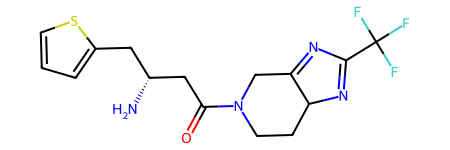

In [17]:
mymol = Chem.MolFromSmiles("N[C@@H](CC(=O)N1CCC2N=C(N=C2C1)C(F)(F)F)CC1=CC=CS1")
mymol

In [18]:
#　当然ですがここのFingerprintはこれまでの計算時の条件と同一にして下さい
myfp = mol2numpy_fp(mymol, radius=2, nBits=1024)

In [22]:
myspace = res.transform([myfp])

In [23]:
myspace.shape

(1, 2)

In [24]:
myspace

PartialTSNEEmbedding([[-8.11865303,  5.26553858]])

In [25]:
data = dict(x=res[:,0],
       y=res[:,1],
        ids = [m.GetProp("_Name") for m in mols],
        img = molsvgs,
        patnum = patnum,
        label=[str(l) for l in hdbscan.labels_]
        )

TOOLTIPS = """
<div>
cluseterID: @label<br>
ROW-ID: @ids<br>
PATENT: @patnum<br>
<div>@img{safe}</div>
</div>
"""
source = ColumnDataSource(data)
"""
デザインしたmymolのTooltip用のデータを付与します。
"""
mymol_data = dict(x=[myspace[0][0]],
                  y=[myspace[0][1]],
                  ids=['my_mol'],
                  img = [mol2svg(mymol)],
                  patnum = ['my idea'],
                  label=['xxxx'])

mymol_source = ColumnDataSource(mymol_data)
p = figure(tooltips=TOOLTIPS, width=800, height=400,)
c = p.circle('x', 'y', size=10, source=source, 
         fill_color=mapper,
         alpha=0.8
        )
p.circle('x',
        'y',
        size=20,
        color='pink',
        source=mymol_source)
handle=show(p, notebook_handle=True)
push_notebook(handle=handle)

- 以上、一つの例ではありましたがDPP4阻害剤の特許を用いてケミカルスペースの可視化、新規化合物の射影を実施しました。tSNEを利用することで各特許の化合物が適当な空間に集約し、HDBSCANを利用したソフトクラスタリングによって適切にクラスタリングできていることが確認できました。より大規模なデータに対して解析を行うときは(RAPIDS)[https://rapids.ai/]などGPUを利用したパッケージの活用も考慮すると良いと思われます。